In [1]:
# 데이터
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import mode

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 모델
import torch
import torch.nn as nn
import torch.nn.functional as F

# 학습
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import GroupKFold

#평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Load

In [3]:
def data_load():
  df_list = []

  for i in range(0, 10):
      path = f"C:/Users/c/Desktop/ML programming/data/MHEALTHDATASET/mHealth_subject{i+1}.log"
      df = pd.read_csv(path, sep='\t', header=None)
      df['subject'] = i+1
      df.rename(columns={df.columns[23]: 'activity'}, inplace=True)
      # activit 0번 : 0 for the null class 삭제
      df = df[df['activity'] != 0]
      df['activity'] = df['activity'] - 1
      df_list.append(df)

  df_all = pd.concat(df_list, ignore_index=True)
  return df_all

In [4]:
df = data_load()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,activity,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,0,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,0,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,0,1


In [5]:
df.shape

(343195, 25)

## EDA

C:\Users\c\AppData\Local\Temp\ipykernel_3412\2537035384.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


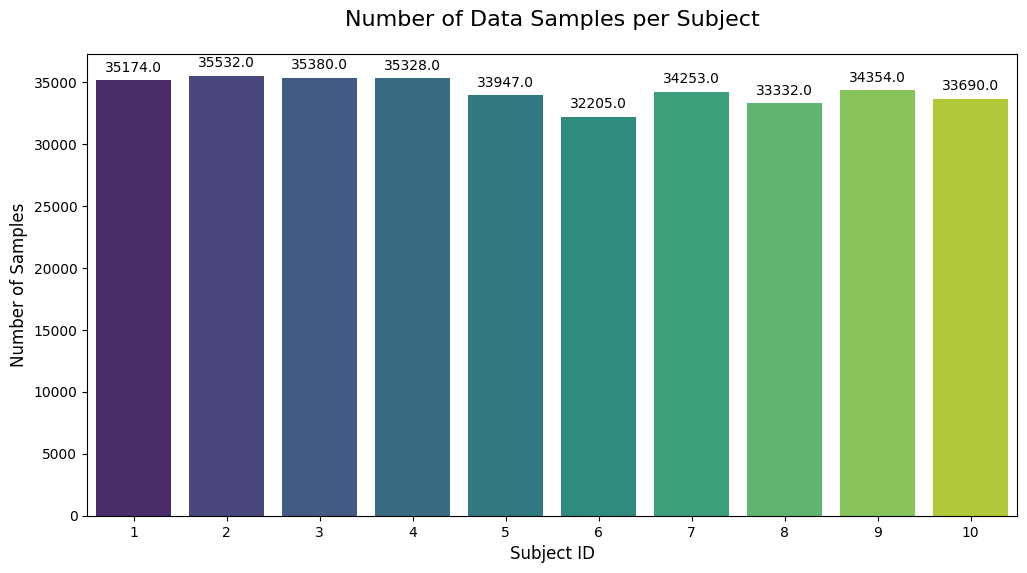

In [6]:
subject_counts = df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Subject', fontsize=16, pad=20)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_3412\1215715953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


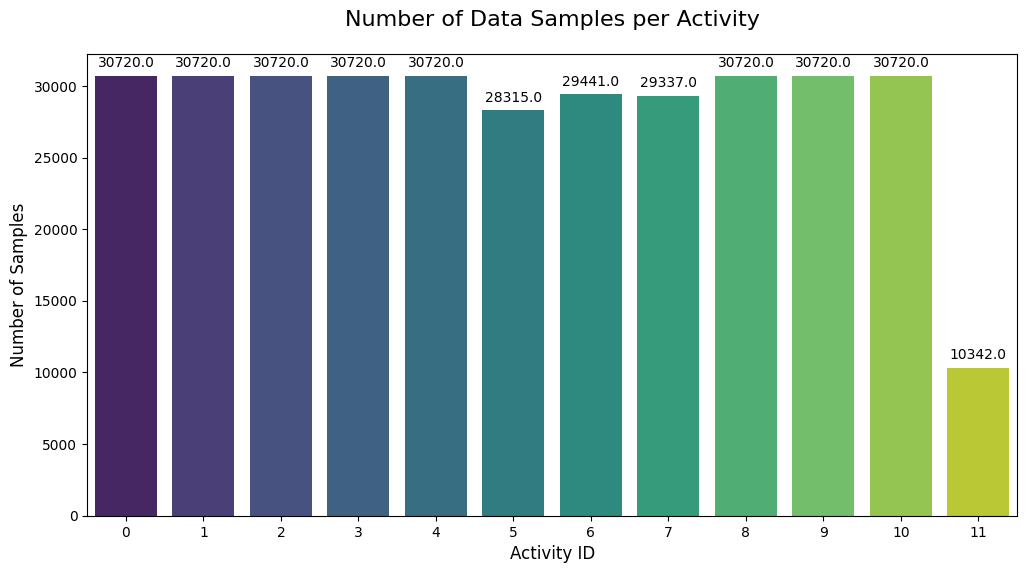

In [7]:
subject_counts = df['activity'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Activity', fontsize=16, pad=20)
plt.xlabel('Activity ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

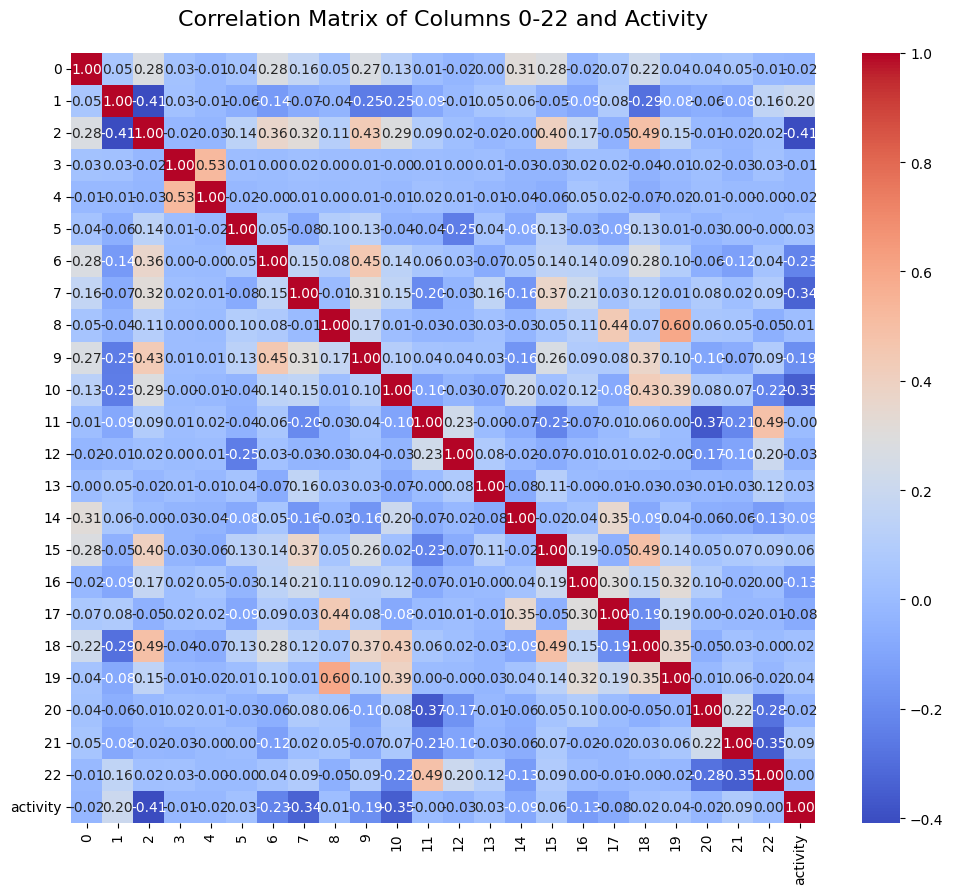

In [8]:
# Calculate the correlation matrix between columns 0-22 and 'activity'
correlation_matrix = df.loc[:, list(range(23)) + ['activity']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Columns 0-22 and Activity', fontsize=16, pad=20)
plt.show()

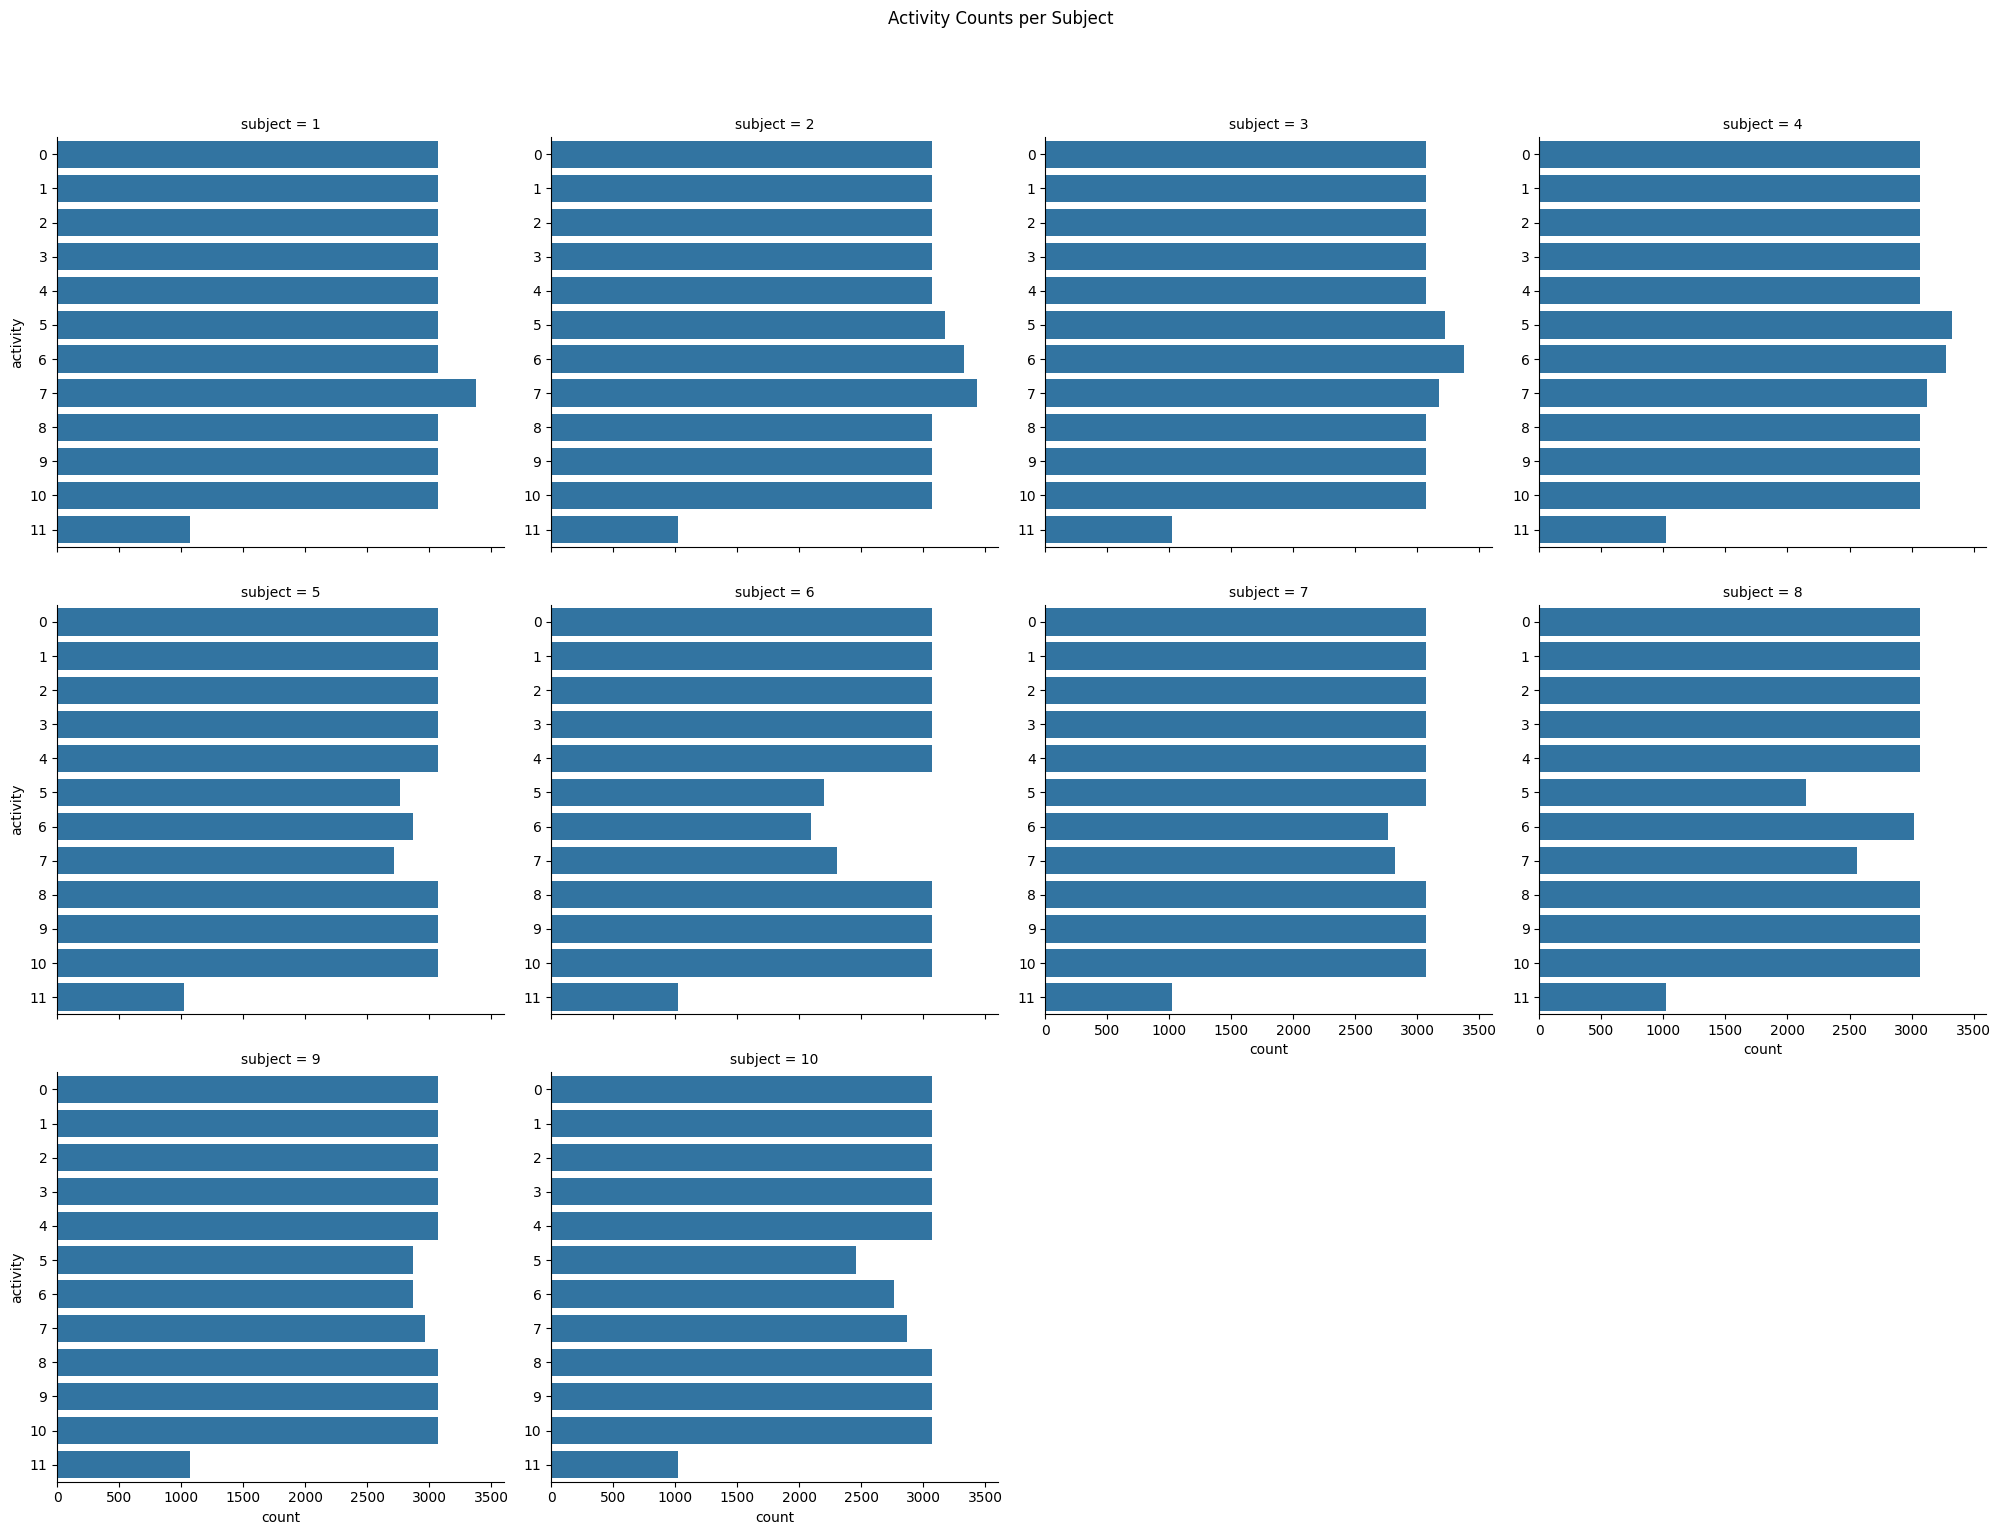

In [9]:
g = sns.catplot(data=df, y='activity', col='subject', kind='count',
                height=5, aspect=1, col_wrap=4, sharey=False)

g.fig.suptitle('Activity Counts per Subject', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Preprocessing

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features_data, labels_data, frame_size, hop_size):
        """
        초기화 메서드.
        - features_data: 피처 데이터 (Pandas DataFrame 또는 NumPy ndarray)
        - labels_data: 라벨 데이터 (Pandas Series 또는 NumPy ndarray)
        """
        # 입력 데이터가 Pandas 객체이면 .values로 NumPy 배열을 추출하고,
        # 이미 NumPy 배열이면 그대로 사용합니다.
        self.features = features_data.values if hasattr(features_data, 'values') else features_data
        self.labels = labels_data.values if hasattr(labels_data, 'values') else labels_data

        self.frame_size = frame_size
        self.hop_size = hop_size

        self.num_frames = (len(self.features) - frame_size) // hop_size + 1

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        start_idx = idx * self.hop_size
        end_idx = start_idx + self.frame_size

        frame = self.features[start_idx:end_idx]
    
        label_window = self.labels[start_idx:end_idx]
        label = mode(label_window)[0]

        """
        center_idx = start_idx + self.frame_size // 2
        label = self.labels[center_idx] 
        """

        frame_tensor = torch.tensor(frame, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return frame_tensor, label_tensor

## Defining Model

In [199]:
# 슬라이딩 윈도우
FRAME_SIZE = 128
HOP_SIZE = 64

# 학습
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 10
N_SPLITS = 5

# 모델
INPUT_SIZE = 23
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_CLASSES = 12
WEIGHT_DECAY = 1e-4
DROPOUT = 0.7

In [191]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        

        # batch_first=True : 입력 데이터의 Shape을 (Batch, Seq, Feature)로 받음
        self.lstm = nn.LSTM(INPUT_SIZE, self.hidden_size, self.num_layers, batch_first=True, dropout=DROPOUT, bidirectional=True)

        # LSTM의 최종 출력(마지막 time-step의 hidden state)을 받아 분류 수행
        self.fc = nn.Linear(self.hidden_size * 2, NUM_CLASSES)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 설정
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        # out: 모든 시점(time-step)에 대한 hidden state 출력 (Batch, Seq, Hidden)
        # _: 마지막 시점의 (hidden state, cell state)
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시점의 hidden state만 사용하여 분류 (Many-to-One)
        out = self.fc(out[:, -1, :])
        return out

## Training

In [192]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [193]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [194]:
def evaluate(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # accuracy와 함께 preds와 labels 리스트를 반환
    return avg_loss, accuracy, all_preds, all_labels

In [200]:
# --- 데이터 로드 ---
df_all = data_load()
X = df_all.iloc[:, :23].values
y = df_all['activity'].values
groups = df_all['subject'].values

# --- 교차 검증 루프 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gkf = GroupKFold(n_splits=N_SPLITS)

cv_histories = []
cv_test_scores = []
all_fold_preds = []
all_fold_labels = []

for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n{'='*20} FOLD {fold+1}/{N_SPLITS} {'='*20}")
    
    # ... 데이터 분할, 스케일링, DataLoader 생성 (이전과 동일) ...
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train, FRAME_SIZE, HOP_SIZE)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val, FRAME_SIZE, HOP_SIZE)
    test_dataset = TimeSeriesDataset(X_test_scaled, y_test, FRAME_SIZE, HOP_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = LSTM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    fold_checkpoint_path = f'best_model_fold_{fold+1}.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=fold_checkpoint_path)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    # --- 학습 루프 (버그 수정된 부분) ---
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # --- 검증 스텝 (정확도 계산 로직 추가) ---
        model.eval()
        val_loss = 0.0
        # *** val_preds, val_labels 리스트를 매 에포크마다 초기화 ***
        val_preds, val_labels = [], [] 
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                # *** 현재 에포크의 예측과 라벨을 리스트에 추가 ***
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        # *** 현재 에포크의 검증 정확도를 계산 ***
        val_accuracy = accuracy_score(val_labels, val_preds)

        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy) # <<< 이제 올바른 값이 들어감

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
            
    cv_histories.append(history)

    # --- Fold별 평가 ---
    print(f"\n--- Evaluating Fold {fold+1} on Test Set ---")
    model.load_state_dict(torch.load(fold_checkpoint_path))
    _, test_accuracy, fold_preds, fold_labels = evaluate(model, test_loader, device, criterion)
    print(f"Fold {fold+1} Test Accuracy: {test_accuracy:.4f}")
    cv_test_scores.append(test_accuracy)

    all_fold_preds.extend(fold_preds)
    all_fold_labels.extend(fold_labels)

# --- 최종 교차 검증 결과 ---
print(f"\n{'='*20} CROSS VALIDATION SUMMARY {'='*20}")
print(f"Average Test Accuracy over {N_SPLITS} folds: {np.mean(cv_test_scores):.4f} (+/- {np.std(cv_test_scores):.4f})")


==================== FOLD 1/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.4321 | Val Loss: 2.3812 | Val Acc: 0.1071
Epoch 2/100 | Train Loss: 2.3821 | Val Loss: 2.3720 | Val Acc: 0.1199
Epoch 3/100 | Train Loss: 2.3628 | Val Loss: 2.3439 | Val Acc: 0.1432
Epoch 4/100 | Train Loss: 2.3793 | Val Loss: 2.3723 | Val Acc: 0.1071
EarlyStopping counter: 1 out of 10
Epoch 5/100 | Train Loss: 2.3753 | Val Loss: 2.3696 | Val Acc: 0.1222
EarlyStopping counter: 2 out of 10
Epoch 6/100 | Train Loss: 2.3773 | Val Loss: 2.3715 | Val Acc: 0.1222
EarlyStopping counter: 3 out of 10
Epoch 7/100 | Train Loss: 2.3638 | Val Loss: 2.3683 | Val Acc: 0.1176
EarlyStopping counter: 4 out of 10
Epoch 8/100 | Train Loss: 2.3556 | Val Loss: 2.4016 | Val Acc: 0.1246
EarlyStopping counter: 5 out of 10
Epoch 9/100 | Train Loss: 2.3661 | Val Loss: 2.3656 | Val Acc: 0.1281
EarlyStopping counter: 6 out of 10
Epoch 10/100 | Train Loss: 2.3515 | Val Loss: 2.3639 | Val Acc: 0.1234
EarlyStopping counter: 7 out of 10
Epoch 11/100 | Train Loss: 2.3493 | Val Loss: 2.3631 |

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3468711893.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 1 Test Accuracy: 0.1798

==================== FOLD 2/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.4344 | Val Loss: 2.3717 | Val Acc: 0.1343
Epoch 2/100 | Train Loss: 2.3748 | Val Loss: 2.3668 | Val Acc: 0.1308
Epoch 3/100 | Train Loss: 2.3564 | Val Loss: 2.3725 | Val Acc: 0.1437
EarlyStopping counter: 1 out of 10
Epoch 4/100 | Train Loss: 2.3223 | Val Loss: 2.2945 | Val Acc: 0.1717
Epoch 5/100 | Train Loss: 2.2987 | Val Loss: 2.3081 | Val Acc: 0.1659
EarlyStopping counter: 1 out of 10
Epoch 6/100 | Train Loss: 2.2806 | Val Loss: 2.3271 | Val Acc: 0.1682
EarlyStopping counter: 2 out of 10
Epoch 7/100 | Train Loss: 2.2591 | Val Loss: 2.2581 | Val Acc: 0.1822
Epoch 8/100 | Train Loss: 2.2473 | Val Loss: 2.2472 | Val Acc: 0.1928
Epoch 9/100 | Train Loss: 2.2120 | Val Loss: 2.2285 | Val Acc: 0.2044
Epoch 10/100 | Train Loss: 2.1909 | Val Loss: 2.2564 | Val Acc: 0.1822
EarlyStopping counter: 1 out of 10
Epoch 11/100 | Train Loss: 2.2092 | Val Loss: 2.2645 | Val Acc: 0.1787
EarlyStopping counter: 2 out of 10
Epoch 12/100 | Train Loss: 2.2023 | Val Loss: 2.2498 

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3468711893.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 2 Test Accuracy: 0.2519

==================== FOLD 3/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.4314 | Val Loss: 2.4016 | Val Acc: 0.0959
Epoch 2/100 | Train Loss: 2.3701 | Val Loss: 2.3878 | Val Acc: 0.1064
Epoch 3/100 | Train Loss: 2.3578 | Val Loss: 2.3808 | Val Acc: 0.1170
Epoch 4/100 | Train Loss: 2.3436 | Val Loss: 2.3375 | Val Acc: 0.1474
Epoch 5/100 | Train Loss: 2.3134 | Val Loss: 2.3783 | Val Acc: 0.1251
EarlyStopping counter: 1 out of 10
Epoch 6/100 | Train Loss: 2.3157 | Val Loss: 2.4889 | Val Acc: 0.1345
EarlyStopping counter: 2 out of 10
Epoch 7/100 | Train Loss: 2.3573 | Val Loss: 2.3794 | Val Acc: 0.1193
EarlyStopping counter: 3 out of 10
Epoch 8/100 | Train Loss: 2.3483 | Val Loss: 2.3839 | Val Acc: 0.1111
EarlyStopping counter: 4 out of 10
Epoch 9/100 | Train Loss: 2.3486 | Val Loss: 2.3768 | Val Acc: 0.1228
EarlyStopping counter: 5 out of 10
Epoch 10/100 | Train Loss: 2.3260 | Val Loss: 2.3333 | Val Acc: 0.1696
Epoch 11/100 | Train Loss: 2.3350 | Val Loss: 2.3733 | Val Acc: 0.1193
EarlyStopping counter: 1 out of 10
Epoch 12/100 | Tra

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3468711893.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 3 Test Accuracy: 0.4633

==================== FOLD 4/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.4241 | Val Loss: 2.3852 | Val Acc: 0.1099
Epoch 2/100 | Train Loss: 2.3717 | Val Loss: 2.3731 | Val Acc: 0.1158
Epoch 3/100 | Train Loss: 2.3517 | Val Loss: 2.3545 | Val Acc: 0.1520
Epoch 4/100 | Train Loss: 2.3477 | Val Loss: 2.4080 | Val Acc: 0.0971
EarlyStopping counter: 1 out of 10
Epoch 5/100 | Train Loss: 2.3755 | Val Loss: 2.3837 | Val Acc: 0.1099
EarlyStopping counter: 2 out of 10
Epoch 6/100 | Train Loss: 2.3633 | Val Loss: 2.3721 | Val Acc: 0.1135
EarlyStopping counter: 3 out of 10
Epoch 7/100 | Train Loss: 2.3530 | Val Loss: 2.3588 | Val Acc: 0.1368
EarlyStopping counter: 4 out of 10
Epoch 8/100 | Train Loss: 2.3423 | Val Loss: 2.3811 | Val Acc: 0.1345
EarlyStopping counter: 5 out of 10
Epoch 9/100 | Train Loss: 2.3209 | Val Loss: 2.3124 | Val Acc: 0.2035
Epoch 10/100 | Train Loss: 2.2634 | Val Loss: 2.2491 | Val Acc: 0.1813
Epoch 11/100 | Train Loss: 2.2526 | Val Loss: 2.2418 | Val Acc: 0.2199
Epoch 12/100 | Train Loss: 2.2323 | Val Loss: 2.2083 

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3468711893.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 4 Test Accuracy: 0.3429

==================== FOLD 5/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.4175 | Val Loss: 2.3774 | Val Acc: 0.1307
Epoch 2/100 | Train Loss: 2.3777 | Val Loss: 2.3704 | Val Acc: 0.1342
Epoch 3/100 | Train Loss: 2.3572 | Val Loss: 2.3404 | Val Acc: 0.1774
Epoch 4/100 | Train Loss: 2.3500 | Val Loss: 2.3413 | Val Acc: 0.1587
EarlyStopping counter: 1 out of 10
Epoch 5/100 | Train Loss: 2.3659 | Val Loss: 2.3549 | Val Acc: 0.1517
EarlyStopping counter: 2 out of 10
Epoch 6/100 | Train Loss: 2.3242 | Val Loss: 2.3183 | Val Acc: 0.1809
Epoch 7/100 | Train Loss: 2.3080 | Val Loss: 2.2733 | Val Acc: 0.2030
Epoch 8/100 | Train Loss: 2.2867 | Val Loss: 2.2759 | Val Acc: 0.1914
EarlyStopping counter: 1 out of 10
Epoch 9/100 | Train Loss: 2.2484 | Val Loss: 2.2201 | Val Acc: 0.2042
Epoch 10/100 | Train Loss: 2.2028 | Val Loss: 2.2163 | Val Acc: 0.2054
Epoch 11/100 | Train Loss: 2.1897 | Val Loss: 2.1687 | Val Acc: 0.2439
Epoch 12/100 | Train Loss: 2.1648 | Val Loss: 2.2069 | Val Acc: 0.2252
EarlyStopping counter: 1 out of 10
Epoch 13/100 | Tr

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3468711893.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 5 Test Accuracy: 0.3252

==================== CROSS VALIDATION SUMMARY ====================
Average Test Accuracy over 5 folds: 0.3126 (+/- 0.0950)


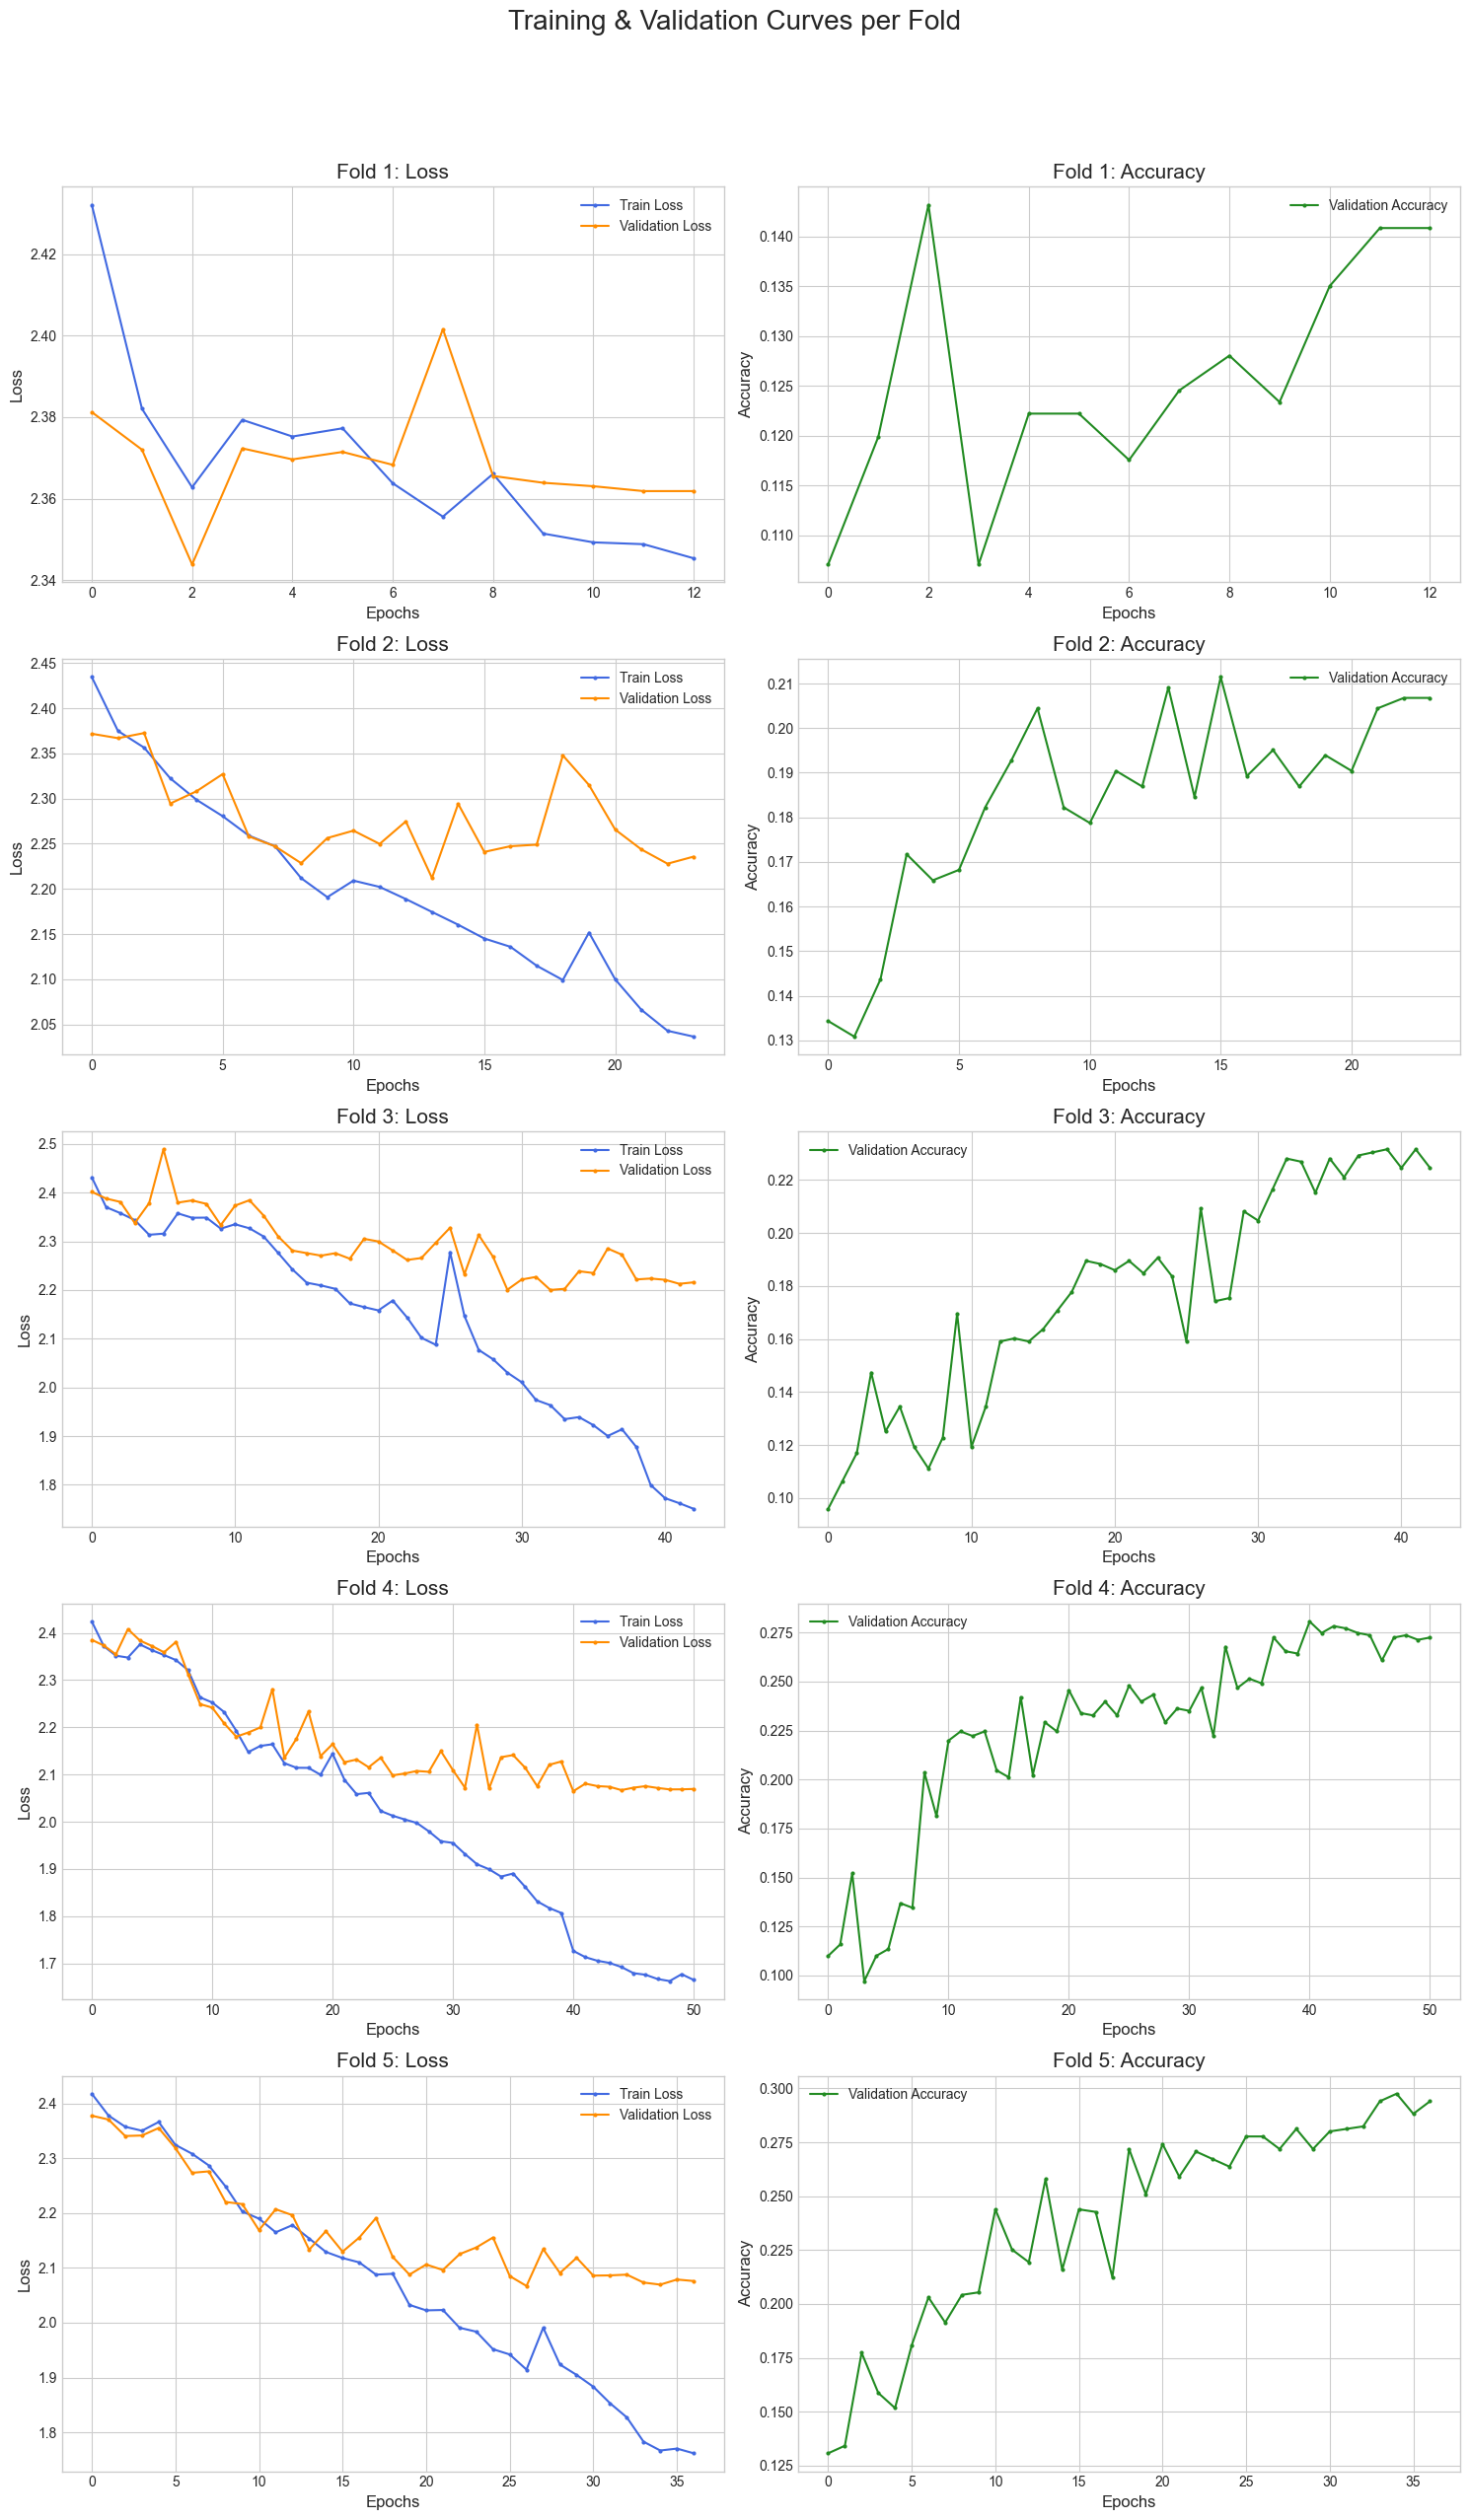

In [201]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(N_SPLITS, 2, figsize=(15, 5 * N_SPLITS))
fig.suptitle('Training & Validation Curves per Fold', fontsize=20, y=1.02)

for i, history in enumerate(cv_histories):
    # Loss 그래프
    ax1 = axes[i, 0]
    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=2)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=2)
    ax1.set_title(f'Fold {i+1}: Loss', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()

    # Accuracy 그래프
    ax2 = axes[i, 1]
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='forestgreen', marker='o', markersize=2)
    ax2.set_title(f'Fold {i+1}: Accuracy', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_3412\3658211361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=fold_names, y=cv_test_scores, palette='viridis')


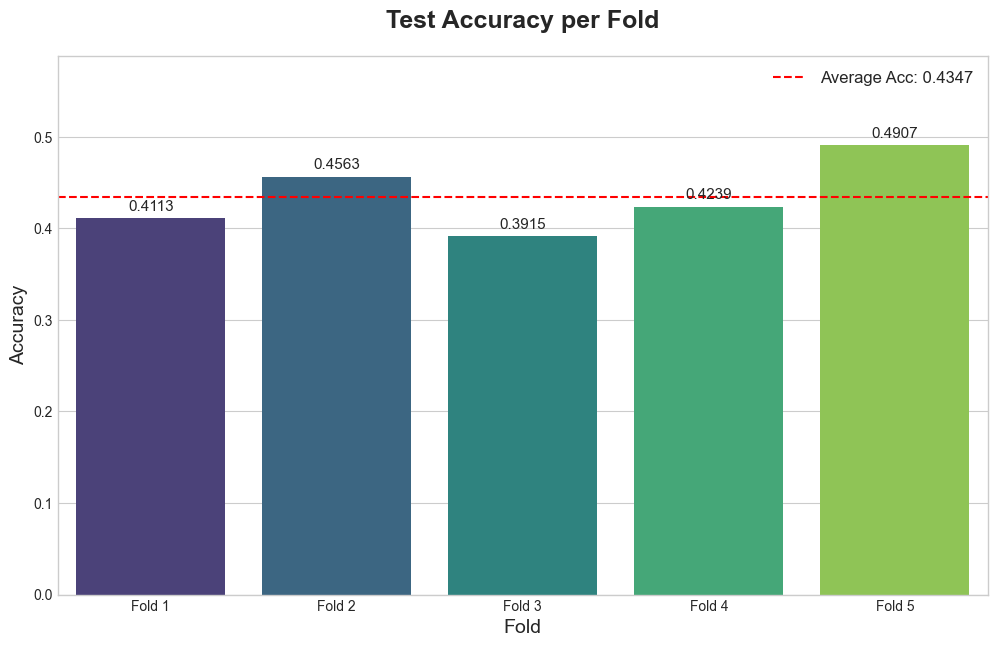

In [134]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Fold 이름 리스트 생성
fold_names = [f'Fold {i+1}' for i in range(N_SPLITS)]
average_accuracy = np.mean(cv_test_scores)

# 막대그래프 생성
bar_plot = sns.barplot(x=fold_names, y=cv_test_scores, palette='viridis')

# 그래프 제목 및 라벨 설정
plt.title('Test Accuracy per Fold', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, max(cv_test_scores) * 1.2) # y축 범위 설정

# 평균 정확도 선 추가
plt.axhline(y=average_accuracy, color='r', linestyle='--', 
            label=f'Average Acc: {average_accuracy:.4f}')

# 각 막대 위에 정확도 값 표시
for index, value in enumerate(cv_test_scores):
    plt.text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom', fontsize=11)

plt.legend(fontsize=12)
plt.show()


==================== AGGREGATED CLASSIFICATION REPORT ====================
                               precision    recall  f1-score   support

           L1: Standing still       0.27      0.88      0.41       768
     L2: Sitting and relaxing       0.51      0.29      0.37       766
               L3: Lying down       0.91      1.00      0.95       770
                  L4: Walking       0.32      0.14      0.20       770
          L5: Climbing stairs       0.26      0.04      0.08       763
      L6: Waist bends forward       0.36      0.32      0.34       706
L7: Frontal elevation of arms       0.50      0.13      0.20       735
L8: Knees bending (crouching)       0.71      0.03      0.05       735
                  L9: Cycling       0.49      0.97      0.66       769
                 L10: Jogging       0.49      0.08      0.14       766
                 L11: Running       0.41      1.00      0.59       768
       L12: Jump front & back       0.00      0.00      0.00       257


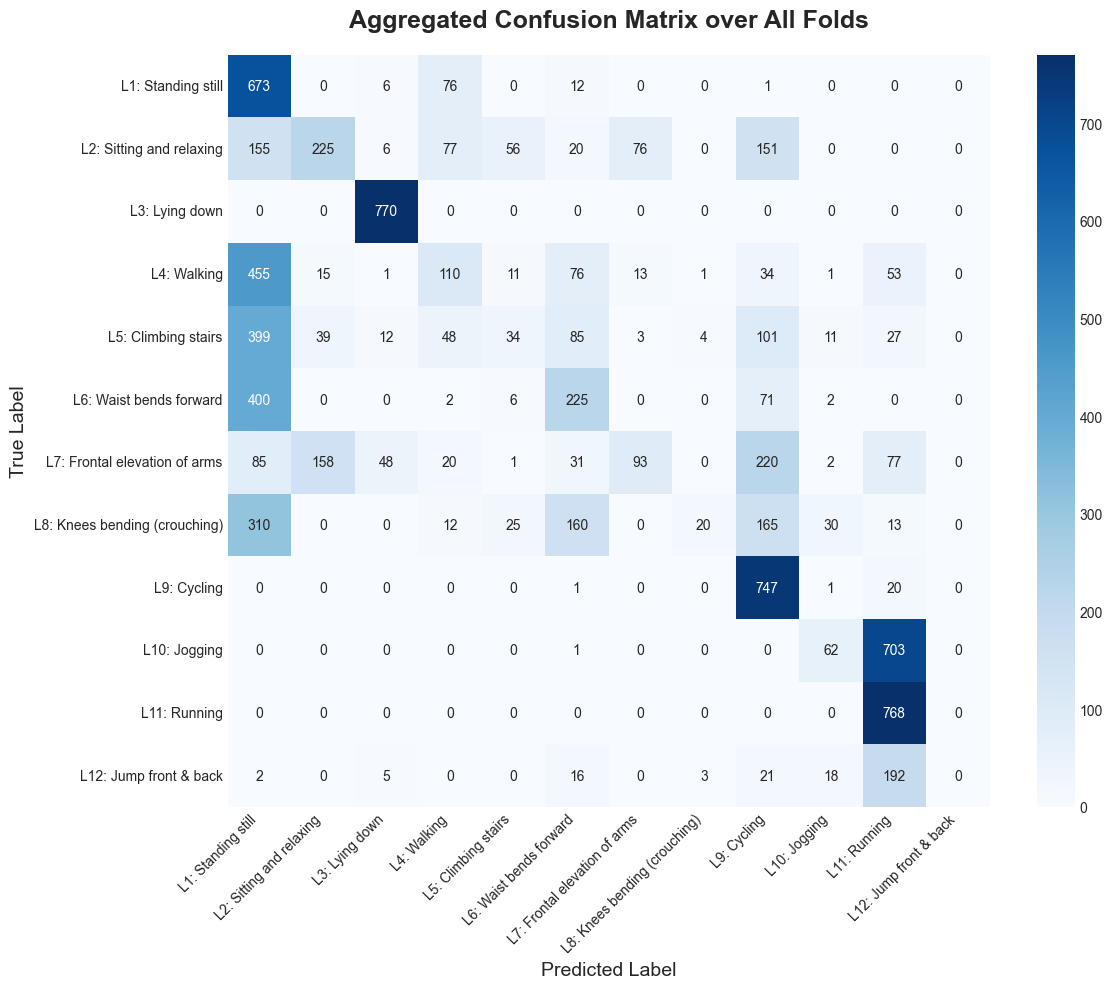

In [135]:
from sklearn.metrics import classification_report, confusion_matrix

# 클래스 이름 정의 (MHEALTH 데이터셋 기준)
class_names = [
    'L1: Standing still', 'L2: Sitting and relaxing', 'L3: Lying down', 
    'L4: Walking', 'L5: Climbing stairs', 'L6: Waist bends forward', 
    'L7: Frontal elevation of arms', 'L8: Knees bending (crouching)', 
    'L9: Cycling', 'L10: Jogging', 'L11: Running', 'L12: Jump front & back'
]
all_possible_labels = list(range(NUM_CLASSES))

# --- Classification Report 출력 ---
print(f"\n{'='*20} AGGREGATED CLASSIFICATION REPORT {'='*20}")
print(classification_report(all_fold_labels, all_fold_preds,
                            target_names=class_names,
                            labels=all_possible_labels,
                            zero_division=0))

# --- Confusion Matrix 시각화 ---
print(f"\n{'='*20} AGGREGATED CONFUSION MATRIX {'='*20}")
cm = confusion_matrix(all_fold_labels, all_fold_preds, labels=all_possible_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Aggregated Confusion Matrix over All Folds', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()